# 📘 Module 3: 机器如何学习？- 数据驱动模型入门 (How Machines Learn)

## 学习目标 (Learning Objectives)

- 理解LSTM如何处理时序数据
- 对比物理模型和数据驱动模型的差异
- 通过可视化理解训练过程
- 认识过拟合与泛化能力的重要性

---

## 🤖 什么是数据驱动模型？

在前两个模块中，我们学习了**物理模型**（如HBV），它使用公式来描述水文过程。

现在，让我们认识另一种完全不同的方法：**数据驱动模型**。

### 一个有趣的类比

想象有两种学生在学习预测河流流量：

| | 物理模型学生 | 数据驱动模型学生 |
|---|-------------|----------------|
| 学习方式 | 背公式、理解原理 | 大量做题、找规律 |
| 需要的知识 | 水文学理论 | 历史数据 |
| 面对新问题 | 应用公式 | 类比以前的题目 |
| 优势 | 能解释为什么 | 可能更准确 |
| 劣势 | 公式可能不完美 | 可能"死记硬背" |

In [ ]:
# 导入必要的库
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import display, HTML
import warnings

# 配置matplotlib以避免Unicode字符问题
matplotlib.rc('axes', unicode_minus=False)  # 在导入plt之前设置
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['figure.figsize'] = (12, 6)

# 过滤警告
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

# 检查GPU可用性
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ 环境设置完成！")
print(f"📟 使用设备: {device}")

# 设置随机种子以确保结果可重复
torch.manual_seed(42)
np.random.seed(42)

✅ 环境设置完成！
📟 使用设备: cpu


## 🧠 Part 1: 认识LSTM

### 什么是LSTM？

**LSTM (Long Short-Term Memory)** 是一种特殊的循环神经网络（RNN），
它有一个"记忆"机制，能够学习时间序列数据中的长期依赖关系。

### 为什么LSTM适合水文建模？

想想河流的流量：
- 今天的流量不仅取决于今天的降雨
- 还取决于过去几天甚至几周的降雨（土壤水分、地下水等）
- LSTM可以"记住"这些历史信息！

### LSTM的"记忆"机制

LSTM有三个"门"来控制信息流：
1. **遗忘门 (Forget Gate)** → 决定丢弃哪些旧信息（类似于蒸发、下渗）
2. **输入门 (Input Gate)** → 决定保留哪些新信息（类似于降雨补给）
3. **输出门 (Output Gate)** → 决定输出什么（类似于产生径流）

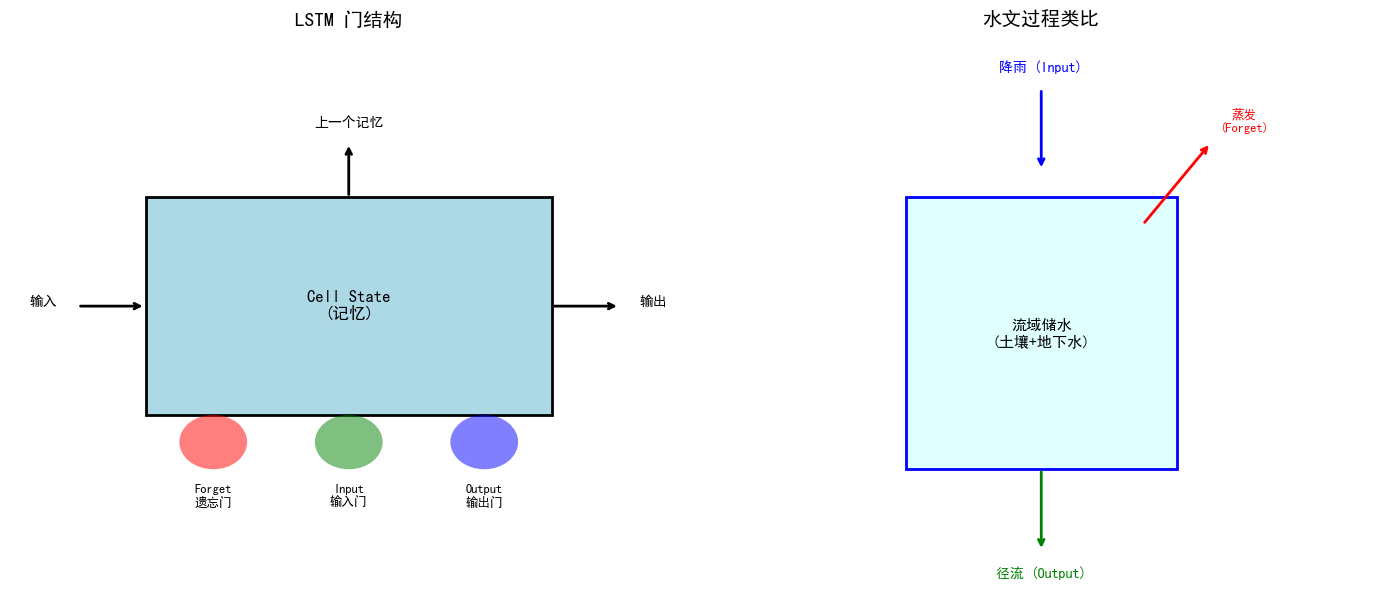

In [2]:
def visualize_lstm_gates():
    """
    可视化LSTM的门机制与水文过程的类比
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 左图：LSTM结构
    ax1 = axes[0]
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)
    ax1.axis('off')
    ax1.set_title('LSTM 门结构', fontsize=14, fontweight='bold')
    
    # 画LSTM单元
    from matplotlib.patches import Rectangle, FancyArrowPatch, Circle
    
    # 主体
    cell = Rectangle((2, 3), 6, 4, fill=True, facecolor='lightblue', 
                      edgecolor='black', linewidth=2)
    ax1.add_patch(cell)
    ax1.text(5, 5, 'Cell State\n(记忆)', fontsize=12, ha='center', va='center')
    
    # 门
    gates = [
        (3, 2.5, 'Forget\n遗忘门', 'red'),
        (5, 2.5, 'Input\n输入门', 'green'),
        (7, 2.5, 'Output\n输出门', 'blue'),
    ]
    
    for x, y, label, color in gates:
        gate = Circle((x, y), 0.5, fill=True, facecolor=color, alpha=0.5)
        ax1.add_patch(gate)
        ax1.text(x, y-1.2, label, fontsize=9, ha='center')
    
    # 箭头
    ax1.annotate('', xy=(5, 8), xytext=(5, 7), 
                arrowprops=dict(arrowstyle='->', lw=2))
    ax1.text(5, 8.3, '上一个记忆', fontsize=10, ha='center')
    
    ax1.annotate('', xy=(1, 5), xytext=(2, 5),
                arrowprops=dict(arrowstyle='<-', lw=2))
    ax1.text(0.5, 5, '输入', fontsize=10, ha='center')
    
    ax1.annotate('', xy=(9, 5), xytext=(8, 5),
                arrowprops=dict(arrowstyle='->', lw=2))
    ax1.text(9.5, 5, '输出', fontsize=10, ha='center')
    
    # 右图：水文类比
    ax2 = axes[1]
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
    ax2.axis('off')
    ax2.set_title('水文过程类比', fontsize=14, fontweight='bold')
    
    # 水箱
    tank = Rectangle((3, 2), 4, 5, fill=True, facecolor='lightcyan',
                     edgecolor='blue', linewidth=2)
    ax2.add_patch(tank)
    ax2.text(5, 4.5, '流域储水\n(土壤+地下水)', fontsize=11, ha='center', va='center')
    
    # 输入箭头（降雨）
    ax2.annotate('', xy=(5, 7.5), xytext=(5, 9),
                arrowprops=dict(arrowstyle='->', lw=2, color='blue'))
    ax2.text(5, 9.3, '降雨 (Input)', fontsize=10, ha='center', color='blue')
    
    # 蒸发箭头
    ax2.annotate('', xy=(7.5, 8), xytext=(6.5, 6.5),
                arrowprops=dict(arrowstyle='->', lw=2, color='red'))
    ax2.text(8, 8.2, '蒸发\n(Forget)', fontsize=9, ha='center', color='red')
    
    # 出流箭头
    ax2.annotate('', xy=(5, 0.5), xytext=(5, 2),
                arrowprops=dict(arrowstyle='->', lw=2, color='green'))
    ax2.text(5, 0, '径流 (Output)', fontsize=10, ha='center', color='green')
    
    plt.tight_layout()
    plt.show()

visualize_lstm_gates()

## 📊 Part 2: 准备数据

在训练LSTM之前，我们需要将数据组织成特定的格式：
- **输入 (X)**: 过去n天的气象数据（降水、温度、PET）
- **输出 (Y)**: 当天的径流

这叫做**滑动窗口 (Sliding Window)** 方法。

In [3]:
def generate_synthetic_data(n_days=1000):
    """
    生成合成的气象-径流数据
    
    我们使用一个简化的物理关系来生成"真实"数据，
    然后让LSTM来学习这个关系。
    """
    # 气象数据
    day_of_year = np.arange(n_days) % 365
    
    # 温度：季节性 + 随机波动
    temp = 15 + 10 * np.sin(2 * np.pi * (day_of_year - 91) / 365)
    temp += np.random.normal(0, 3, n_days)
    
    # 降水：随机事件
    precip = np.zeros(n_days)
    rain_prob = 0.3 + 0.1 * np.sin(2 * np.pi * day_of_year / 365)  # 季节性变化
    for i in range(n_days):
        if np.random.random() < rain_prob[i]:
            precip[i] = np.random.exponential(scale=10)
    
    # PET：与温度相关
    pet = np.maximum(0, 0.5 + 0.2 * temp + np.random.normal(0, 0.5, n_days))
    
    # 生成"真实"径流（使用简化的水箱模型）
    discharge = np.zeros(n_days)
    storage = 100  # 初始储水
    
    for t in range(n_days):
        # 降水输入
        storage += precip[t] * 0.7  # 70%的降水形成有效补给
        
        # 蒸发损失
        evap = min(pet[t] * 0.8, storage * 0.05)
        storage -= evap
        
        # 非线性出流
        discharge[t] = 0.1 * storage + 0.05 * max(0, storage - 150)
        storage -= discharge[t]
        storage = max(0, storage)
    
    # 添加一些观测噪声
    discharge += np.random.normal(0, 0.5, n_days)
    discharge = np.maximum(0, discharge)
    
    return precip, temp, pet, discharge

# 生成数据
precip, temp, pet, discharge = generate_synthetic_data(1000)

print(f"📊 数据生成完成！")
print(f"   样本数: {len(precip)} 天")
print(f"   降水均值: {precip.mean():.2f} mm/day")
print(f"   径流均值: {discharge.mean():.2f} mm/day")

📊 数据生成完成！
   样本数: 1000 天
   降水均值: 3.44 mm/day
   径流均值: 1.70 mm/day


In [4]:
def create_sequences(precip, temp, pet, discharge, seq_length=30):
    """
    创建训练序列
    
    Parameters:
    -----------
    seq_length : int
        使用过去多少天的数据来预测当天径流
        
    Returns:
    --------
    X : np.ndarray, shape (n_samples, seq_length, n_features)
    y : np.ndarray, shape (n_samples,)
    """
    # 堆叠特征
    features = np.stack([precip, temp, pet], axis=1)  # (n_days, 3)
    
    X, y = [], []
    
    for i in range(seq_length, len(features)):
        # 过去seq_length天的特征
        X.append(features[i-seq_length:i])
        # 当天的径流
        y.append(discharge[i])
    
    return np.array(X), np.array(y)

# 创建序列
SEQ_LENGTH = 30  # 使用过去30天的数据
X, y = create_sequences(precip, temp, pet, discharge, seq_length=SEQ_LENGTH)

print(f"\n📐 数据形状:")
print(f"   X shape: {X.shape} - (样本数, 序列长度, 特征数)")
print(f"   y shape: {y.shape} - (样本数,)")


📐 数据形状:
   X shape: (970, 30, 3) - (样本数, 序列长度, 特征数)
   y shape: (970,) - (样本数,)


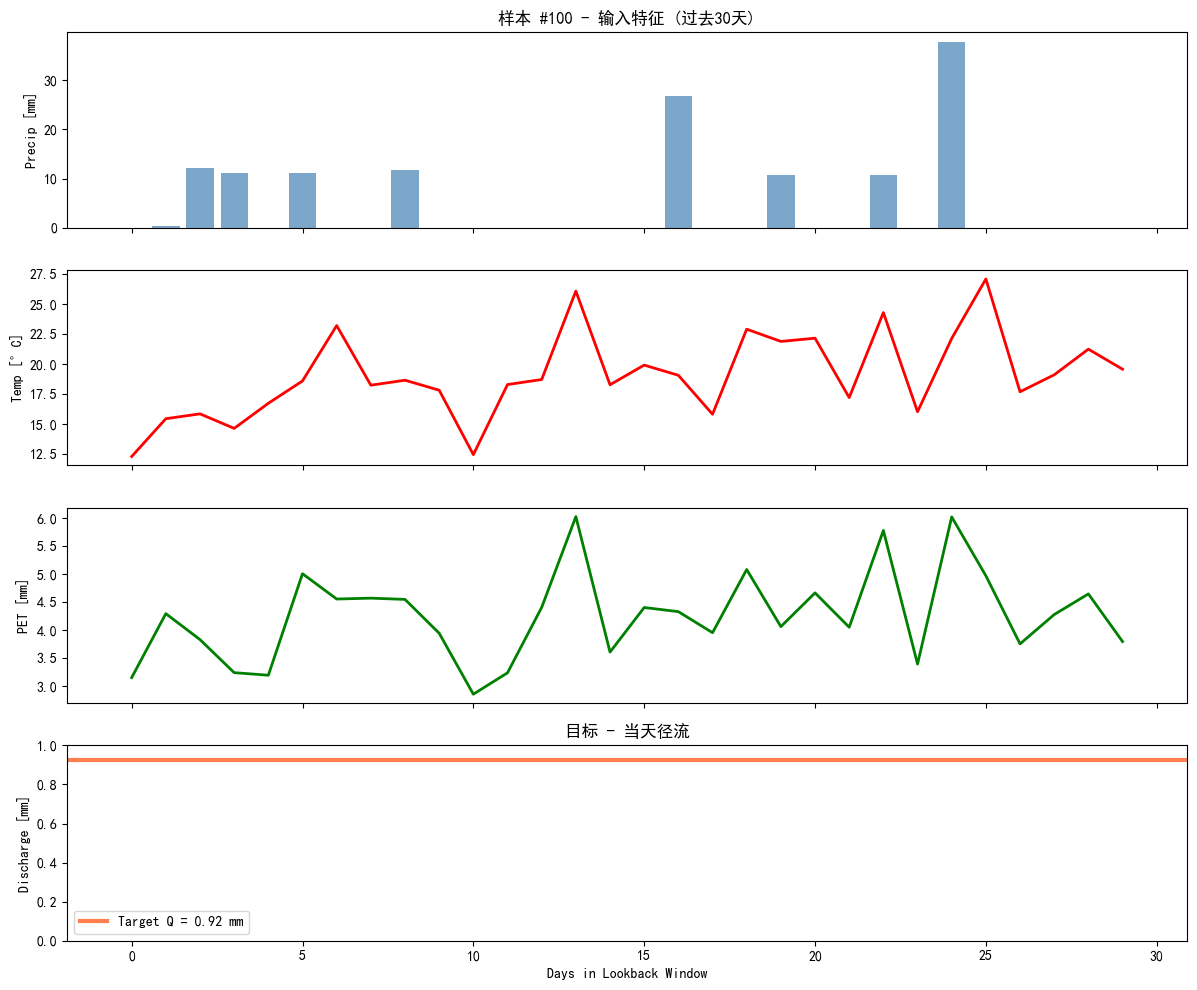

In [5]:
# 可视化一个样本
def visualize_sample(X, y, sample_idx=100):
    """
    可视化一个训练样本
    """
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    sample = X[sample_idx]  # (seq_length, 3)
    target = y[sample_idx]
    
    days = np.arange(SEQ_LENGTH)
    
    # 降水
    axes[0].bar(days, sample[:, 0], color='steelblue', alpha=0.7)
    axes[0].set_ylabel('Precip [mm]')
    axes[0].set_title(f'样本 #{sample_idx} - 输入特征 (过去{SEQ_LENGTH}天)', fontweight='bold')
    
    # 温度
    axes[1].plot(days, sample[:, 1], 'r-', linewidth=2)
    axes[1].set_ylabel('Temp [°C]')
    
    # PET
    axes[2].plot(days, sample[:, 2], 'g-', linewidth=2)
    axes[2].set_ylabel('PET [mm]')
    
    # 目标
    axes[3].axhline(y=target, color='coral', linewidth=3, label=f'Target Q = {target:.2f} mm')
    axes[3].set_ylabel('Discharge [mm]')
    axes[3].set_xlabel('Days in Lookback Window')
    axes[3].set_title('目标 - 当天径流', fontweight='bold')
    axes[3].legend()
    
    plt.tight_layout()
    plt.show()

visualize_sample(X, y, sample_idx=100)

## 🏗️ Part 3: 构建LSTM模型

现在让我们用PyTorch构建一个简单的LSTM模型。

In [6]:
class SimpleLSTM(nn.Module):
    """
    简单的LSTM水文模型
    
    结构：
    输入 -> LSTM层 -> 全连接层 -> 输出
    """
    
    def __init__(self, input_size=3, hidden_size=32, num_layers=1, dropout=0.0):
        super(SimpleLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # 全连接输出层
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        """
        前向传播
        
        x: (batch_size, seq_length, input_size)
        """
        # LSTM层
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # 取最后一个时间步的输出
        last_output = lstm_out[:, -1, :]
        
        # 全连接层
        output = self.fc(last_output)
        
        return output.squeeze(-1)

# 创建模型
model = SimpleLSTM(input_size=3, hidden_size=32, num_layers=1)
model = model.to(device)

print("🏗️ 模型结构:")
print(model)
print(f"\n📊 参数总数: {sum(p.numel() for p in model.parameters()):,}")

🏗️ 模型结构:
SimpleLSTM(
  (lstm): LSTM(3, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

📊 参数总数: 4,769


## 🎓 Part 4: 训练模型 - 观察学习过程

现在是最激动人心的部分 - 看看模型如何从数据中"学习"！

In [7]:
# 准备数据
# 分割训练集和测试集
train_size = int(len(X) * 0.7)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 标准化
X_mean, X_std = X_train.mean(axis=(0,1)), X_train.std(axis=(0,1))
y_mean, y_std = y_train.mean(), y_train.std()

X_train_norm = (X_train - X_mean) / (X_std + 1e-8)
X_test_norm = (X_test - X_mean) / (X_std + 1e-8)
y_train_norm = (y_train - y_mean) / (y_std + 1e-8)
y_test_norm = (y_test - y_mean) / (y_std + 1e-8)

# 转换为PyTorch张量
X_train_t = torch.FloatTensor(X_train_norm).to(device)
X_test_t = torch.FloatTensor(X_test_norm).to(device)
y_train_t = torch.FloatTensor(y_train_norm).to(device)
y_test_t = torch.FloatTensor(y_test_norm).to(device)

# 创建DataLoader
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"📊 数据划分:")
print(f"   训练集: {len(X_train)} 样本")
print(f"   测试集: {len(X_test)} 样本")

📊 数据划分:
   训练集: 679 样本
   测试集: 291 样本


In [8]:
def train_model(model, train_loader, X_test_t, y_test_t, epochs=50, lr=0.01):
    """
    训练模型并记录过程
    
    Returns:
    --------
    train_losses : 训练损失历史
    test_losses : 测试损失历史
    predictions_history : 每10个epoch的预测结果
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    predictions_history = {}
    
    for epoch in range(epochs):
        # 训练模式
        model.train()
        epoch_loss = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # 评估模式
        model.eval()
        with torch.no_grad():
            test_pred = model(X_test_t)
            test_loss = criterion(test_pred, y_test_t).item()
            test_losses.append(test_loss)
            
            # 保存一些epoch的预测结果
            if epoch in [0, 5, 10, 20, 49]:
                predictions_history[epoch] = test_pred.cpu().numpy()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {test_loss:.4f}")
    
    return train_losses, test_losses, predictions_history

# 重新初始化模型
model = SimpleLSTM(input_size=3, hidden_size=32, num_layers=1).to(device)

print("🚀 开始训练...\n")
train_losses, test_losses, pred_history = train_model(
    model, train_loader, X_test_t, y_test_t, epochs=50, lr=0.01
)
print("\n✅ 训练完成！")

🚀 开始训练...

Epoch  10/50 | Train Loss: 0.4745 | Test Loss: 0.5494
Epoch  20/50 | Train Loss: 0.4848 | Test Loss: 0.5063
Epoch  30/50 | Train Loss: 0.4316 | Test Loss: 0.5374
Epoch  40/50 | Train Loss: 0.3143 | Test Loss: 0.6213
Epoch  50/50 | Train Loss: 0.2773 | Test Loss: 0.7103

✅ 训练完成！


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

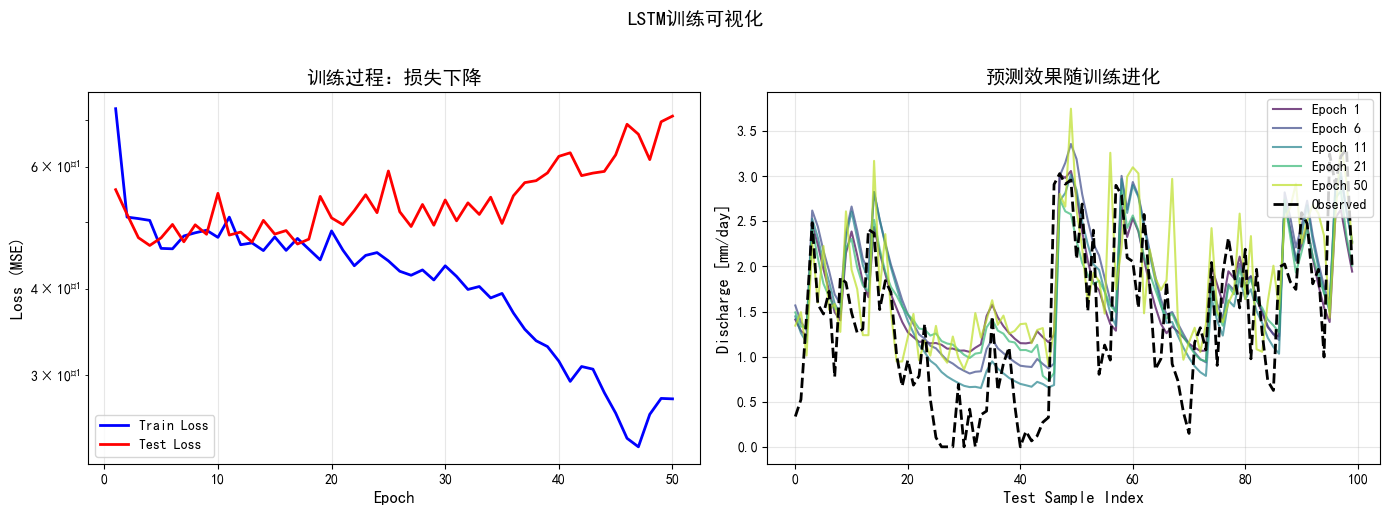

In [9]:
# 可视化训练过程
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：损失曲线
epochs_range = np.arange(1, len(train_losses) + 1)
axes[0].plot(epochs_range, train_losses, 'b-', linewidth=2, label='Train Loss')
axes[0].plot(epochs_range, test_losses, 'r-', linewidth=2, label='Test Loss')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('训练过程：损失下降', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# 右图：预测效果演变
colors = plt.cm.viridis(np.linspace(0, 0.9, len(pred_history)))

for (epoch, pred), color in zip(pred_history.items(), colors):
    # 反标准化
    pred_real = pred * y_std + y_mean
    axes[1].plot(pred_real[:100], color=color, alpha=0.7, label=f'Epoch {epoch+1}')

axes[1].plot(y_test[:100], 'k--', linewidth=2, label='Observed')
axes[1].set_xlabel('Test Sample Index', fontsize=12)
axes[1].set_ylabel('Discharge [mm/day]', fontsize=12)
axes[1].set_title('预测效果随训练进化', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.suptitle('LSTM训练可视化', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 💡 观察要点

1. **损失下降**：随着训练进行，模型的预测误差逐渐减小
2. **从乱画到逼近**：初期预测很差，后期越来越准确
3. **训练vs测试**：两条曲线的差距反映了泛化能力

## ⚠️ Part 5: 过拟合实验 - 数据量的重要性

现在让我们做一个实验：如果只用很少的数据训练，会发生什么？

In [10]:
def overfit_experiment(X, y, train_sizes=[10, 50, 100, 300, 500]):
    """
    演示不同数据量下的过拟合现象
    """
    results = {}
    
    # 固定测试集
    X_test_exp = X[-200:]
    y_test_exp = y[-200:]
    
    # 标准化（用全部数据的统计量）
    X_mean_exp = X[:-200].mean(axis=(0,1))
    X_std_exp = X[:-200].std(axis=(0,1))
    y_mean_exp = y[:-200].mean()
    y_std_exp = y[:-200].std()
    
    X_test_norm_exp = (X_test_exp - X_mean_exp) / (X_std_exp + 1e-8)
    y_test_norm_exp = (y_test_exp - y_mean_exp) / (y_std_exp + 1e-8)
    
    X_test_t_exp = torch.FloatTensor(X_test_norm_exp).to(device)
    y_test_t_exp = torch.FloatTensor(y_test_norm_exp).to(device)
    
    for train_size in train_sizes:
        print(f"\n训练数据量: {train_size} 天")
        
        # 使用前train_size个样本训练
        X_train_exp = X[:train_size]
        y_train_exp = y[:train_size]
        
        X_train_norm_exp = (X_train_exp - X_mean_exp) / (X_std_exp + 1e-8)
        y_train_norm_exp = (y_train_exp - y_mean_exp) / (y_std_exp + 1e-8)
        
        X_train_t_exp = torch.FloatTensor(X_train_norm_exp).to(device)
        y_train_t_exp = torch.FloatTensor(y_train_norm_exp).to(device)
        
        train_dataset_exp = TensorDataset(X_train_t_exp, y_train_t_exp)
        batch_size_exp = min(32, train_size)
        train_loader_exp = DataLoader(train_dataset_exp, batch_size=batch_size_exp, shuffle=True)
        
        # 训练新模型
        model_exp = SimpleLSTM(input_size=3, hidden_size=32, num_layers=1).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model_exp.parameters(), lr=0.01)
        
        train_losses_exp = []
        test_losses_exp = []
        
        for epoch in range(50):
            model_exp.train()
            for batch_X, batch_y in train_loader_exp:
                optimizer.zero_grad()
                outputs = model_exp(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
            
            # 记录损失
            model_exp.eval()
            with torch.no_grad():
                train_pred = model_exp(X_train_t_exp)
                train_loss = criterion(train_pred, y_train_t_exp).item()
                train_losses_exp.append(train_loss)
                
                test_pred = model_exp(X_test_t_exp)
                test_loss = criterion(test_pred, y_test_t_exp).item()
                test_losses_exp.append(test_loss)
        
        # 最终预测
        model_exp.eval()
        with torch.no_grad():
            final_pred = model_exp(X_test_t_exp).cpu().numpy()
            final_pred_real = final_pred * y_std_exp + y_mean_exp
        
        results[train_size] = {
            'train_losses': train_losses_exp,
            'test_losses': test_losses_exp,
            'predictions': final_pred_real
        }
        
        print(f"  最终训练损失: {train_losses_exp[-1]:.4f}")
        print(f"  最终测试损失: {test_losses_exp[-1]:.4f}")
    
    return results, y_test_exp

print("🔬 开始过拟合实验...")
results, y_test_exp = overfit_experiment(X, y)

🔬 开始过拟合实验...

训练数据量: 10 天
  最终训练损失: 0.0996
  最终测试损失: 0.9196

训练数据量: 50 天
  最终训练损失: 0.2957
  最终测试损失: 2.6007

训练数据量: 100 天
  最终训练损失: 0.3562
  最终测试损失: 1.0824

训练数据量: 300 天
  最终训练损失: 0.2742
  最终测试损失: 0.8118

训练数据量: 500 天
  最终训练损失: 0.1384
  最终测试损失: 0.8791


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

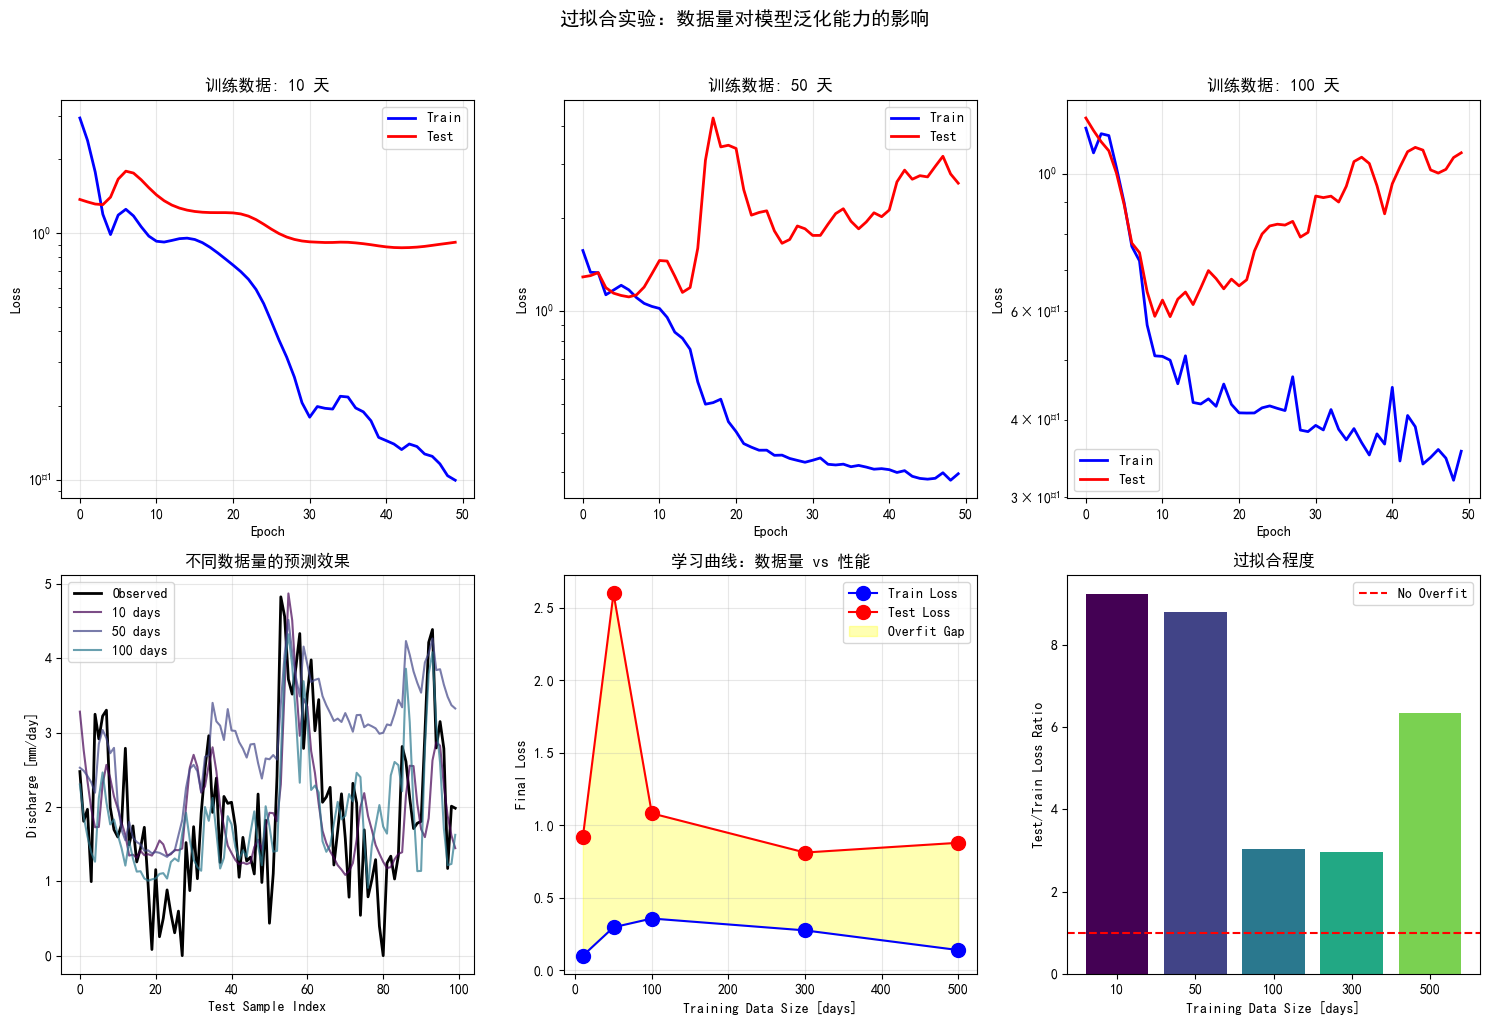

In [13]:
# 可视化过拟合实验结果
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

train_sizes = list(results.keys())
colors = plt.cm.viridis(np.linspace(0, 0.8, len(train_sizes)))

# 上排：损失曲线对比
for idx, (train_size, color) in enumerate(zip(train_sizes, colors)):
    if idx < 3:
        ax = axes[0, idx]
    else:
        continue
        
    ax.plot(results[train_size]['train_losses'], 'b-', label='Train', linewidth=2)
    ax.plot(results[train_size]['test_losses'], 'r-', label='Test', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'训练数据: {train_size} 天', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

# 下排：预测对比
axes[1, 0].plot(y_test_exp[:100], 'k-', linewidth=2, label='Observed')
for train_size, color in zip(train_sizes[:3], colors[:3]):
    axes[1, 0].plot(results[train_size]['predictions'][:100], 
                   color=color, alpha=0.7, label=f'{train_size} days')
axes[1, 0].set_xlabel('Test Sample Index')
axes[1, 0].set_ylabel('Discharge [mm/day]')
axes[1, 0].set_title('不同数据量的预测效果', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 学习曲线
final_train_losses = [results[s]['train_losses'][-1] for s in train_sizes]
final_test_losses = [results[s]['test_losses'][-1] for s in train_sizes]

axes[1, 1].plot(train_sizes, final_train_losses, 'bo-', markersize=10, label='Train Loss')
axes[1, 1].plot(train_sizes, final_test_losses, 'ro-', markersize=10, label='Test Loss')
axes[1, 1].fill_between(train_sizes, final_train_losses, final_test_losses, 
                        color='yellow', alpha=0.3, label='Overfit Gap')
axes[1, 1].set_xlabel('Training Data Size [days]')
axes[1, 1].set_ylabel('Final Loss')
axes[1, 1].set_title('学习曲线：数据量 vs 性能', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 过拟合程度
overfit_ratio = [final_test_losses[i] / final_train_losses[i] for i in range(len(train_sizes))]
axes[1, 2].bar(range(len(train_sizes)), overfit_ratio, color=colors)
axes[1, 2].set_xticks(range(len(train_sizes)))
axes[1, 2].set_xticklabels([str(s) for s in train_sizes])
axes[1, 2].axhline(y=1, color='red', linestyle='--', label='No Overfit')
axes[1, 2].set_xlabel('Training Data Size [days]')
axes[1, 2].set_ylabel('Test/Train Loss Ratio')
axes[1, 2].set_title('过拟合程度', fontweight='bold')
axes[1, 2].legend()

plt.suptitle('过拟合实验：数据量对模型泛化能力的影响', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 💡 关键发现

1. **数据太少时**（如10天）：
   - 训练损失很低（模型"记住"了所有训练数据）
   - 测试损失很高（模型在新数据上表现很差）
   - 这就是**过拟合 (Overfitting)**！

2. **数据量增加时**：
   - 训练损失和测试损失的差距逐渐缩小
   - 模型的**泛化能力 (Generalization)** 提高

3. **这就是为什么**：
   - 数据驱动模型需要大量数据
   - 论文研究"学习曲线"很重要

## 📚 总结

### 数据驱动模型 vs 物理模型

| 特性 | 物理模型 (HBV) | 数据驱动模型 (LSTM) |
|------|---------------|--------------------|
| **学习方式** | 基于公式 | 从数据中学习 |
| **数据需求** | 较少 | 较多 |
| **可解释性** | 高（参数有物理意义） | 低（黑盒子） |
| **外推能力** | 较好 | 较差 |
| **计算需求** | 低 | 高（GPU加速） |
| **精度上限** | 受限于公式简化 | 可能更高 |

### 本模块学到了什么？

1. **LSTM的工作原理**：通过"记忆"机制学习时序依赖
2. **数据准备**：滑动窗口方法
3. **训练过程**：损失下降、参数优化
4. **过拟合问题**：数据量的重要性

### 下一步学习

在下一个模块中，我们将学习如何**评估模型**——
不同的指标（NSE、KGE、信息熵）各有什么优缺点？